In [27]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

In [28]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [29]:
# Load Data
data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [30]:
# Set Up Filter
cust_filter = data['cust_id'] == 'klant_69'
date_filter = data['procesdag'].dt.dayofweek <= 4
data = data.where(date_filter & cust_filter).dropna()

data['procesdag']=pd.to_datetime(data['procesdag'])
data = data.set_index(data.procesdag, drop=True)

data = data['2016-01-01':'2020-01-01']
start_date = datetime(2016, 1, 1)
end_date = datetime(2020, 1, 1)

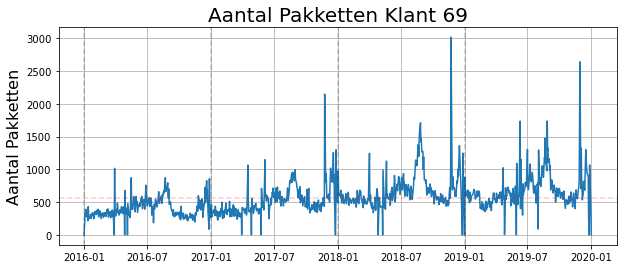

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(data['aantal_pakketten'])
plt.title('Aantal Pakketten Klant 69', fontsize=20)
plt.ylabel('Aantal Pakketten', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(data['aantal_pakketten'].mean(), color='r', alpha=0.2, linestyle='--')
plt.grid()

In [32]:
first_diff = data['aantal_pakketten'].diff()[1:]
werkelijk = data['aantal_pakketten']

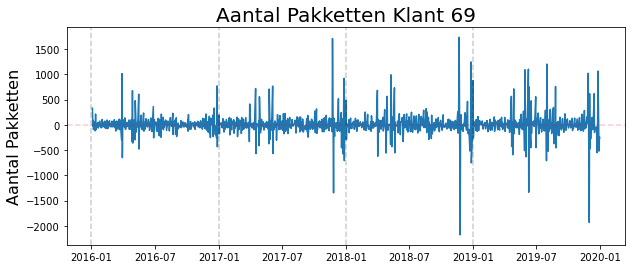

In [33]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Aantal Pakketten Klant 69', fontsize=20)
plt.ylabel('Aantal Pakketten', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

In [34]:
# Train And Test
train_end = datetime(2019, 9, 1)
test_end = datetime(2019, 10, 1)

train_data = werkelijk[:train_end]
test_data = werkelijk[train_end + timedelta(days=1):test_end]

In [35]:
# Define Model
model = ARMA(train_data, order=(6, 6))

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so infe

In [36]:
# Fit Model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 8.000316143035889


In [37]:
# Summary
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:       aantal_pakketten   No. Observations:                  956
Model:                     ARMA(6, 6)   Log Likelihood               -6334.706
Method:                       css-mle   S.D. of innovations            182.457
Date:                Thu, 26 Nov 2020   AIC                          12697.412
Time:                        17:08:24   BIC                          12765.491
Sample:                    01-01-2016   HQIC                         12723.343
                         - 08-30-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    562.8768     53.477     10.526      0.000     458.063     667.690
ar.L1.aantal_pakketten    -0.3131      0.491     -0.637      0.524      -1.276       0.650
ar.L

In [38]:
# Prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [39]:
# Predictions And Residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

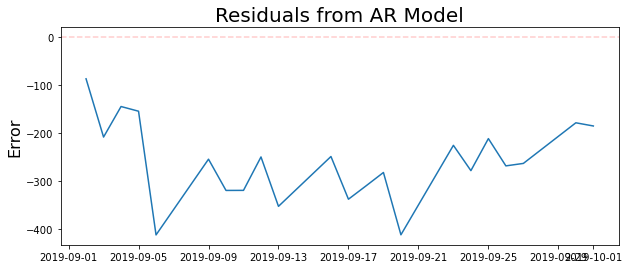

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

(array([737303., 737307., 737311., 737315., 737319., 737323., 737327.,
        737331., 737333.]),
 <a list of 9 Text major ticklabel objects>)

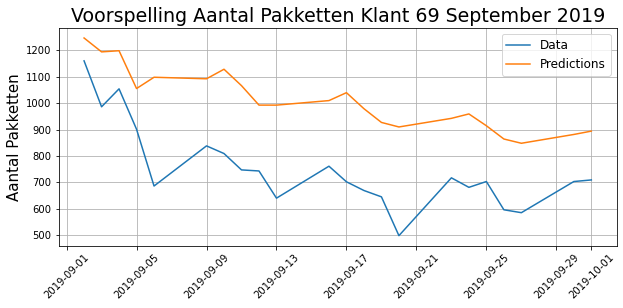

In [43]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Voorspelling Aantal Pakketten Klant 69 September 2019', fontsize=19)
plt.ylabel('Aantal Pakketten', fontsize=15)
plt.grid()
plt.xticks(rotation=45)

In [42]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 271.3224366314792


In [48]:
correlation_matrix = np.corrcoef(test_data, predictions)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2.
print(r_squared)

0.7348048510333407


(array([737303., 737307., 737311., 737315., 737319., 737323., 737327.,
        737331., 737333.]),
 <a list of 9 Text major ticklabel objects>)

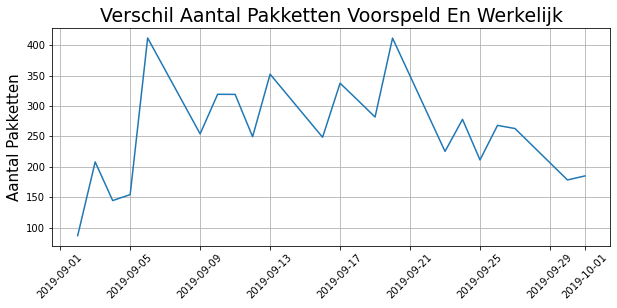

In [47]:
plt.figure(figsize=(10,4))
diff = predictions - test_data
plt.plot(diff)
plt.title('Verschil Aantal Pakketten Voorspeld En Werkelijk', fontsize=19)
plt.ylabel('Aantal Pakketten', fontsize=15)
plt.grid()
plt.xticks(rotation=45)